# Featuretools: Feature Engineering
As introducted in the topic *[Pandas] Data Cleaning*, clean data is used as the input for analytical tasks. However, to build a good predictive model (in both performance and computation), a lot more works need to be done in order to improve data quality. These kind of tasks are called [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering), they get data into the appropriate format and reveal hidden insights. Feature engineering tasks are technically simple, but they do require some domain knowledge. This makes feature engineering more of an art than a science.

In [ ]:
import numpy as np
import pandas as pd
import janitor
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score as AUC

from feature_engine.transformation import LogCpTransformer, PowerTransformer
from feature_engine.transformation import BoxCoxTransformer, YeoJohnsonTransformer
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.encoding import RareLabelEncoder

import category_encoders as ce
import featuretools as ft

np.set_printoptions(precision=4, suppress=True)
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

## 1. Data preprocessing

### 1.1. Scaling
Scaling is a preprocessing technique defined only on numerical variables, where the scaled variable distributes the same as the original one but does have specific properties.
- *Min-max scaling*: to have the min of $0$ and max of $1$
- *Standardization*: to have the mean of $0$ and standard deviation of $1$
- *Manhattan normalization*: to have the absolute values sum up to $1$
- *Euclidean normalization*: to have the squared values sum up to $1$

In [1]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, suppress=True)

from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

#### Min-max scaling
Many Machine Learning algorithms assume all variables are on the same scale, typically $[0;1]$. The formula for rescaling to $[a;b]$ is:

$$\mathbf{x}'=\frac{\mathbf{x}-\mathbf{x}_{min}}{\mathbf{x}_{max}-\mathbf{x}_{min}}(b-a)+a$$

In [7]:
df = pd.DataFrame({
    'x': [17, 22, 25, 30, 38],
    'y': [75, 81, 32, 23, 55]
})

scaler = MinMaxScaler(feature_range=(0,1))
dataScaled = scaler.fit_transform(df.values)
dfScaled = pd.DataFrame(dataScaled, columns=['x_scaled', 'y_scaled'])

df.join(dfScaled)

x   y  x_scaled  y_scaled
0  17  75  0.000000  0.896552
1  22  81  0.238095  1.000000
2  25  32  0.380952  0.155172
3  30  23  0.619048  0.000000
4  38  55  1.000000  0.551724

#### Standardization
Also called *z-score* scaling, it is a technique that transforms a variable so that it has a mean of $0$ and a standard deviation of $1$. Standardization is strongly recommended as the default method for data preprocessing. The formula for standardizing $x$ is:

$$\mathbf{x}'=\frac{\mathbf{x}-\mu_\mathbf{x}}{\sigma_\mathbf{x}}$$

In [9]:
df = pd.DataFrame({
    'x': [17, 22, 25, 30, 38],
    'y': [75, 81, 32, 23, 55]
})

scaler = StandardScaler()
dataScaled = scaler.fit_transform(df.values)
dfScaled = pd.DataFrame(dataScaled, columns=['x_scaled', 'y_scaled'])

df.join(dfScaled)

x   y  x_scaled  y_scaled
0  17  75 -1.310622  0.953649
1  22  81 -0.613483  1.216121
2  25  32 -0.195199 -0.927401
3  30  23  0.501940 -1.321110
4  38  55  1.617363  0.078742

#### Normalizing
This technique ensures the vector has a total length of 1. The length can be either Manhattan distance ($L_1$) $\|\mathbf{x}\|_1 = |x_1|+|x_2|+\dots+|x_n|$ or Euclidean distance ($L_2$) $\|\mathbf{x}\|_2 = \sqrt{x_1^2+x_2^2+\dots+x_n^2}$. The formula for normalizing is:

$$\mathbf{x}'=\frac{\mathbf{x}}{\|\mathbf{x}\|}$$

In [12]:
df = pd.DataFrame({
    'x': [17, 22, 25, 30, 38],
    'y': [75, 81, 32, 23, 55]
})

scaler = Normalizer(norm='l1')
dataScaled = scaler.fit_transform(df.values.T).T
dfScaled = pd.DataFrame(dataScaled, columns=['x_scaled', 'y_scaled'])

df.join(dfScaled)

x   y  x_scaled  y_scaled
0  17  75  0.128788  0.281955
1  22  81  0.166667  0.304511
2  25  32  0.189394  0.120301
3  30  23  0.227273  0.086466
4  38  55  0.287879  0.206767

### 1.2. Transformation
Sometimes real world data distribute not very nice, while most transformation techiniques do not affect the distribution. Imagine the label in a regression problem is mostly small values, then Machine Learning algorithms will have a hard time *learning* higher values. By taking advantage of mathematical functions, Data Scientists can control the distribution of data to make them more *nature*.

In [58]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from feature_engine.transformation import LogCpTransformer, PowerTransformer
from feature_engine.transformation import BoxCoxTransformer, YeoJohnsonTransformer
from feature_engine.wrappers import SklearnTransformerWrapper

np.set_printoptions(precision=4, suppress=True)
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

#### Logarithm
This popular technique has the ability to make right skewed data distribute normally. The formula of the transformation is:

$$\mathbf{x}'=\log_b{(\mathbf{x}+c)}$$

Some notable tips when using [`LogCpTransformer`]:
- It works only on features contain all postive values.
- Different base values $b$ can be used, the most common ones are: $e$, $2$ and $10$.
- The term $c$ (usually $c=1$) is added to $\mathbf{x}$ to make sure the transformed values are all positive, since $\log{(x+1)}>\log1=0$.
- If the input values are very large, log transformation will not work. Thus, I insert a min-max scaler before it.

[`LogCpTransformer`]: https://feature-engine.readthedocs.io/en/latest/api_doc/transformation/LogCpTransformer.html

In [88]:
np.random.seed(7)
x = stats.skewnorm.rvs(a=4, loc=1, size=10000)
df = pd.DataFrame({'x': x})

transformer = make_pipeline(
    SklearnTransformerWrapper(MinMaxScaler()),
    LogCpTransformer(base='10', C=1),
)
dfTransformed = transformer.fit_transform(df)

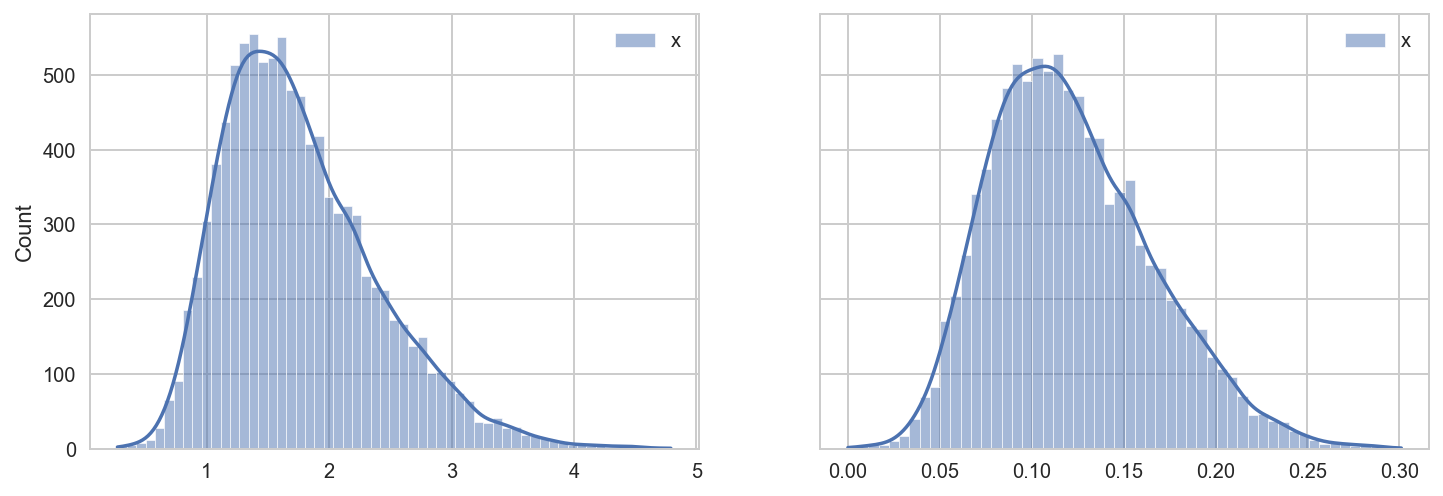

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
sns.histplot(df, ax=ax[0], kde=True, edgecolor='w')
sns.histplot(dfTransformed, ax=ax[1], kde=True, edgecolor='w')
plt.show()

#### Box-Cox
[Box-Cox transform] is a member of [power transform] family. It has the effect of making data more normal distribution-like. The transformation is given by a [piecewise function] as below:

$$
\mathbf{x}'=
\begin{cases}
    {\dfrac {\mathbf{x}^{\lambda}-1}{\lambda}}&{\text{if }}\lambda\neq 0\\
    \log\mathbf{x}&{\text{if }}\lambda=0
\end{cases}
$$

We implement this transformation via the class [`BoxCoxTransformer`]. It wraps the function [`boxcox()`] which estimates the value of $\lambda$ that maximizes log-likelihood.

[Box-Cox transform]: https://en.wikipedia.org/wiki/Power_transform#Box–Cox_transformation
[power transform]: https://en.wikipedia.org/wiki/Power_transform
[piecewise function]: https://en.wikipedia.org/wiki/Piecewise
[`BoxCoxTransformer`]: https://feature-engine.readthedocs.io/en/latest/api_doc/transformation/BoxCoxTransformer.html
[`boxcox()`]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html

In [90]:
np.random.seed(7)
x = stats.skewnorm.rvs(a=4, loc=1, size=10000)
df = pd.DataFrame({'x': x})

transformer = BoxCoxTransformer()
dfTransformed = transformer.fit_transform(df)

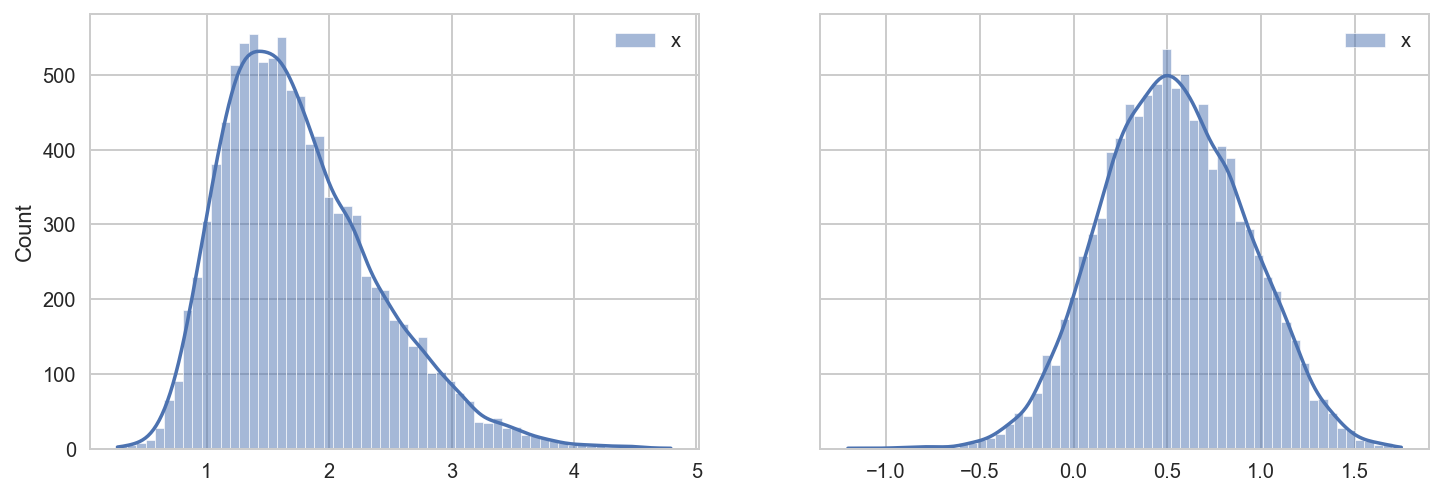

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
sns.histplot(df, ax=ax[0], kde=True, edgecolor='w')
sns.histplot(dfTransformed, ax=ax[1], kde=True, edgecolor='w')
plt.show()

#### Yeo-Johnson
[Yeo-Johnson transform] is another member of power transform family. It extends Box-Cox transform to handle nagative input data, using the following function:

$$
\mathbf{x}'=
\begin{cases}
    \dfrac{(\mathbf{x}+1)^{\lambda}-1}{\lambda}       & \text{if }\lambda\neq 0\text{ and }\mathbf{x}\geq 0 \\
    \log(\mathbf{x}+1)                                & \text{if }\lambda=    0\text{ and }\mathbf{x}\geq 0 \\
    -\dfrac{(-\mathbf{x}+1)^{2-\lambda}-1}{2-\lambda} & \text{if }\lambda\neq 2\text{ and }\mathbf{x}\leq 0 \\
    -\log(-\mathbf{x}+1)                              & \text{if }\lambda=    0\text{ and }\mathbf{x}\geq 0 \\
\end{cases}
$$

It can be implemented via the class [`YeoJohnsonTransformer`].

[Yeo-Johnson transform]: https://en.wikipedia.org/wiki/Power_transform#Yeo–Johnson_transformation
[`YeoJohnsonTransformer`]: https://feature-engine.readthedocs.io/en/latest/api_doc/transformation/YeoJohnsonTransformer.html

In [93]:
np.random.seed(7)
x = stats.skewnorm.rvs(a=4, loc=1, size=10000)
df = pd.DataFrame({'x': x})

transformer = YeoJohnsonTransformer()
dfTransformed = transformer.fit_transform(df)

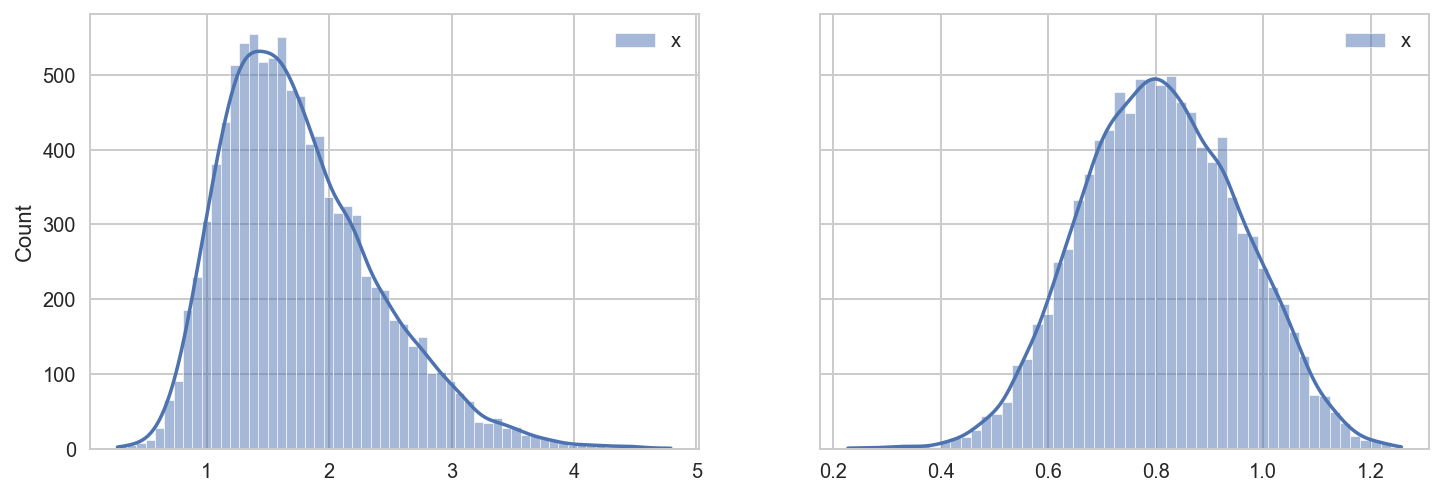

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
sns.histplot(df, ax=ax[0], kde=True, edgecolor='w')
sns.histplot(dfTransformed, ax=ax[1], kde=True, edgecolor='w')
plt.show()

### 1.2. Bucketizing
Bucketizing (or binning) refers to the tasks that put data into larger bins. Doing bucketizing means sacrifying information, however it makes data more regularized and thus prevents overfitting. Either numerical and categorical variables can be binned.

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

#### Discretizating

In [34]:
df = pd.DataFrame({'x': [17, 22, 25, 30, 38]})

group = pd.cut(
    df.x,
    bins=[0, 20, 30, 100],
    right=False,
    labels=['A', 'B', 'C'])

df.assign(group=group)

x group
0  17     A
1  22     B
2  25     B
3  30     C
4  38     C

#### Clustering

In [48]:
np.random.seed(1)
df = pd.DataFrame({
    'x': np.random.randint(10, 100, size=10),
    'y': np.random.randint(10, 100, size=10)
})

clusterer = KMeans(3, random_state=0)
group = clusterer.fit_predict(df.values)

df.assign(group=group)

x   y  group
0  47  86      2
1  22  81      2
2  82  16      1
3  19  35      0
4  85  60      1
5  15  30      0
6  89  28      1
7  74  94      2
8  26  21      0
9  11  38      0

#### Mapping

In [2]:
df = pd.DataFrame({'x': ['England', 'France', 'Germany', 'Korea', 'Japan']})

x_map = df.x.map({
    'England': 'Europe', 'France': 'Europe', 'Germany': 'Europe',
    'Korea': 'Asia', 'Japan': 'Asia'
})

df.assign(x_map=x_map)

x   x_map
0  England  Europe
1   France  Europe
2  Germany  Europe
3    Korea    Asia
4    Japan    Asia

### 1.3. Encoding
Encoding is the technique that transforms a categorical variable to numerical variable(s). This is important because most modern Machine Learning algorithms require input features to be numerical.

In [9]:
import numpy as np
import pandas as pd
import category_encoders as ce

#### Ordinal encoding
[`OrdinalEncoder`](https://contrib.scikit-learn.org/category_encoders/ordinal.html)
transforms categorical columns into unique numbers starting from 0. The disadvantage is that the categories are ordered randomly, which can add unexpected noises that hurt model performance. It also provides an option to pass a dictionary for custom order.

In [10]:
df = pd.DataFrame({
    'education': ['Highschool', 'Bachelor', 'Master', 'PhD']
})

In [11]:
encoder = ce.OrdinalEncoder()
df['encodeEdu'] = encoder.fit_transform(df.education)
df

education  encodeEdu
0  Highschool          1
1    Bachelor          2
2      Master          3
3         PhD          4

#### One-hot encoding
[`OneHotEncoder`](https://contrib.scikit-learn.org/category_encoders/onehot.html)
generates a binary feature for each category. This technique will expand the dataset which can lead to curse of dimensionality and over memory because of storing sparse data. A variant is sometimes used, call Dummy Encoding which cuts the last feature and encode the corresponding class using vectors of $0$.

In [12]:
df = pd.DataFrame({
    'fruit': ['Apple', 'Apple', 'Orange', 'Mango', 'Mango']
})

In [13]:
encoder = ce.OneHotEncoder(use_cat_names=True)
xEncoded = encoder.fit_transform(df.fruit)

df.join(xEncoded)

fruit  fruit_Apple  fruit_Orange  fruit_Mango
0   Apple            1             0            0
1   Apple            1             0            0
2  Orange            0             1            0
3   Mango            0             0            1
4   Mango            0             0            1

#### Rare encoding
[`RareLabelEncoder`](https://feature-engine.readthedocs.io/en/1.0.x/encoding/RareLabelEncoder.html)
is more of a preprocessing technique than an encoder, as it does not returns a numerical value, which is what we are expecting. However, it is still an useful method to gather rare categories into a single group to reduces noises.

In this example, the data is about what phone operating system people are using. Beside popular Android and iOS, there are also low market share ones. As these observations are definitely not crucial to our model, and we want to focus on large categories (make more money, larger market), it would be better to group them into a single group.

In [4]:
np.random.seed(7)
df = pd.DataFrame({
    'osPhone': np.random.choice(
        ['Android', 'iOS', 'Windows', 'Blackberry', 'Bada', 'Symbian', 'Meego'],
        size=1000, p=[.4, .32, .12, .10, .03, .02, .01]
    )
})
df.value_counts().rename('count').to_frame().reset_index()

osPhone  count
0     Android    408
1         iOS    309
2     Windows    130
3  Blackberry     99
4        Bada     30
5     Symbian     17
6       Meego      7

In [5]:
from feature_engine.encoding import RareLabelEncoder
encoder = RareLabelEncoder(tol=0.05, n_categories=5)
encoder.fit_transform(df).value_counts().rename('count').to_frame().reset_index()

osPhone  count
0     Android    408
1         iOS    309
2     Windows    130
3  Blackberry     99
4        Rare     54

#### Helmert encoding
[`HelmertEncoder`](https://contrib.scikit-learn.org/category_encoders/helmert.html)
uses the occuring order of categories in a feature to performce encoding. It ignores the first category, and for each category starting from the second one, it create a feature so that:
- Equals $-1$ for all previous categories
- Equals a category's own rank for itself
- Equals $0$ elsewhere

In [15]:
df = pd.DataFrame({
    'education': ['Highschool', 'Bachelor', 'Master', 'PhD'],
    'target': [5, 7, 3, 4]
})

In [16]:
encoder = ce.HelmertEncoder()
dfEncode = encoder.fit_transform(df[['education']], df.target)
dfEncode.join(df)

intercept  education_0  education_1  education_2   education  target
0          1         -1.0         -1.0         -1.0  Highschool       5
1          1          1.0         -1.0         -1.0    Bachelor       7
2          1          0.0          2.0         -1.0      Master       3
3          1          0.0          0.0          3.0         PhD       4

#### Count encoding
[`CountEncoder`](https://contrib.scikit-learn.org/category_encoders/count.html) encodes each category using an integer of how many times or a float of how frequently it occurs in the dataset.

In [17]:
df = pd.DataFrame({
    'fruit': ['Apple', 'Apple', 'Mango', 'Mango', 'Mango']
})

In [18]:
encoder = ce.CountEncoder(normalize=True)
encoder.fit_transform(df.fruit)

fruit
0    0.4
1    0.4
2    0.6
3    0.6
4    0.6

#### Target encoding
[`TargetEncoder`](https://contrib.scikit-learn.org/category_encoders/targetencoder.html)
is the most popular encoder used in Kaggle competitions. The main idea is to replace each category $c$ of a categorial feature $\mathbf{x}$ with the mean of target associated with that category, $y_c$. However, this encoding strategy suffers from *data leakage*, as we are kind of *leaking the answer before teaching our machinary student*. This is a significant disadvantage which leads to overfitting. To solve this, we smooth the encoded values by pushing it towards the population mean $\bar{y}$:

$$x_c=wy_c+(1-w)\bar{y}$$

Here, $w$ follows a logistic distribution parameterized by the category size $n_c$, so that our encoder assigns more credit to $y_c$ when $n_c$ is large and prefer population mean $\bar{y}$ for small categories. The smoothing effect is controled via two hyperparameters, min samples leaf $k$ and smoothing coefficient $f$, given as:

$$w=\frac{1}{1+\exp\left(-\dfrac{n_c-k}{f}\right)}$$

We can see that, the weight of a very small category (when $n_c\ll k$) is approximately $0$. In the simple example below, our categories have only 2 or 3 observations; so if we set $k=10$, they will uniformally replaced with $\bar{y}=0.6$. And a higher value of $f$ indicates a flatter logistic curve as well as stronger regularization effect.

Another strategy to tackle *data leakage* is excluding the current row from the calculation of mean target, implemented via 
[`LeaveOneOutEncoder`](https://contrib.scikit-learn.org/category_encoders/leaveoneout.html)
. Notice this will return different encoding values within a category.

In [21]:
df = pd.DataFrame({
    'education': ['Highschool']*3 + ['Bachelor']*2 + ['Master']*3 + ['PhD']*2,
    'target': [0,1,0] + [0,1] + [1,1,0] + [1,1]
})

encoder1 = ce.TargetEncoder(smoothing=0, min_samples_leaf=0)
encoder2 = ce.TargetEncoder(smoothing=1, min_samples_leaf=10)
encoder3 = ce.TargetEncoder(smoothing=1, min_samples_leaf=1)
encoder4 = ce.TargetEncoder(smoothing=1, min_samples_leaf=2)
encoder5 = ce.TargetEncoder(smoothing=10, min_samples_leaf=1)
encoder6 = ce.LeaveOneOutEncoder()

dfEncode1 = encoder1.fit_transform(df.education, df.target)
dfEncode2 = encoder2.fit_transform(df.education, df.target)
dfEncode3 = encoder3.fit_transform(df.education, df.target)
dfEncode4 = encoder4.fit_transform(df.education, df.target)
dfEncode5 = encoder5.fit_transform(df.education, df.target)
dfEncode6 = encoder6.fit_transform(df.education, df.target)

df.assign(
    noSmooth = dfEncode1.education,
    veryHardPenalty = dfEncode2.education,
    weakPush = dfEncode3.education,
    strongPushWithK = dfEncode4.education,
    strongPushWithF = dfEncode5.education,
    leaveOneOut = dfEncode6.education
)

education  target  noSmooth  veryHardPenalty  weakPush  strongPushWithK  \
0  Highschool       0  0.333333         0.599757  0.365121         0.405051   
1  Highschool       1  0.333333         0.599757  0.365121         0.405051   
2  Highschool       0  0.333333         0.599757  0.365121         0.405051   
3    Bachelor       0  0.500000         0.599966  0.526894         0.550000   
4    Bachelor       1  0.500000         0.599966  0.526894         0.550000   
5      Master       1  0.666667         0.600061  0.658720         0.648737   
6      Master       1  0.666667         0.600061  0.658720         0.648737   
7      Master       0  0.666667         0.600061  0.658720         0.648737   
8         PhD       1  1.000000         0.600134  0.892423         0.800000   
9         PhD       1  1.000000         0.600134  0.892423         0.800000   

   strongPushWithF  leaveOneOut  
0         0.453378          0.5  
1         0.453378          0.0  
2         0.453378          0.5  
3         0.547502          1.0  
4         0.547502          0.0  
5         0.636656          0.5  
6         0.636656          0.5  
7         0.636656          1.0  
8         0.809992          1.0  
9         0.809992          1.0

#### M-estimate encoding
[`MEstimateEncoder`] is a simplified version of Target Encoder with same functionality but has only a tunable hyperparameter $m$, smoothing factor. We first define a mask vector that activates category $c$: $\mathbf{i}_c(n)=\mathbf{1}[x_n=x_c]$, the encoding formula is given as:

$$x_c=\frac
{\mathbf{i}_c^\text{T}\mathbf{y} + m\bar{y}}
{\mathbf{i}_c^\text{T}\mathbf{1} + m}
$$

Now let's explain what do these ugly things mean. First, $\mathbf{i}_c^\text{T}\mathbf{y}$ is the [dot product] of the mask vector and the target, it computes the sum of target associated with category $c$. The part $\mathbf{i}_c^\text{T}\mathbf{1}$ is another dot product, it counts the number of observations of category $c$. We can also add a small normal distributed noise into training data

[dot product]: https://en.wikipedia.org/wiki/Dot_product
[`MEstimateEncoder`]: https://contrib.scikit-learn.org/category_encoders/mestimate.html

In [24]:
df = pd.DataFrame({
    'education': ['Highschool']*3 + ['Bachelor']*2 + ['Master']*3 + ['PhD']*2,
    'target': [0,1,0] + [0,1] + [1,1,0] + [1,1]
})

encoder1 = ce.MEstimateEncoder(m=0)
encoder2 = ce.MEstimateEncoder(m=1)
encoder3 = ce.MEstimateEncoder(m=10)

dfEncode1 = encoder1.fit_transform(df.education, df.target)
dfEncode2 = encoder2.fit_transform(df.education, df.target)
dfEncode3 = encoder3.fit_transform(df.education, df.target)

df.assign(
    noSmooth = dfEncode1.education,
    weekSmooth = dfEncode2.education,
    strongSmooth = dfEncode3.education,
).drop(columns='target').drop_duplicates()

education  noSmooth  weekSmooth  strongSmooth
0  Highschool  0.333333    0.400000      0.538462
3    Bachelor  0.500000    0.533333      0.583333
5      Master  0.666667    0.650000      0.615385
8         PhD  1.000000    0.866667      0.666667

#### Weight of Evidence
Weight of Evidence is a concept exists in credit scoring and risk management, being generally described as a measure of separation between good and bad things. When applied in Machine Learning, this method is used exclusively on binary target, implemented as [`WOEEncoder`]. It has the following formula:

$$x_c=\log\frac{\text{P}(x=x_c|y=1)}{\text{P}(x=x_c|y=0)}$$

It's clear to see in this equation, the numerator is the probability of observing category $c$ considering only postitive labeled data, and thus it refers to *good things*. The same inference can also be applied to the denominator. One thing to notice is that when calculating these probabilities, a small quantity is add to the denominators to (1) prevent zero division error and (2) add regularization effect.

A great advantage that WoE has, is that it makes our categorical feature resemble log-odds, and is thus well suited for Logistic Regression. This encoding strategy returns a positive value when a category is *better than average*, negative value when a category is *worse than average*. Let's see how it works in action.

[`WOEEncoder`]: https://contrib.scikit-learn.org/category_encoders/woe.html

In [25]:
df = pd.DataFrame({
    'education': ['Highschool']*3 + ['Bachelor']*2 + ['Master']*3 + ['PhD']*2,
    'target': [0,1,0] + [0,1] + [1,1,0] + [1,1]
})

In [27]:
encoder = ce.WOEEncoder(regularization=1)
dfEncode = encoder.fit_transform(df.education, df.target)

In [28]:
df[['education']].assign(woe=dfEncode.education).drop_duplicates()

education       woe
0  Highschool -0.693147
3    Bachelor -0.287682
5      Master  0.117783
8         PhD  0.810930

## 2. Feature synthesis
We have already known many techniques to transform a single feature, but how about their combinations? Of course Data Scientists can use their domain knowledge in a creative way to create new ones, but there are still many combinations we would never even think about. To effectively do this, we need to (1) create so many features and (2) select the best ones from them.

The first problem is exactly what [Featuretools] solves, via an algorithm called [Deep Feature Synthesis] (DFS). It has the abiliy to generate new features from a single table or from a number of related tables, automatically and efficiency.

[Featuretools]: https://featuretools.alteryx.com/en/stable/index.html
[Deep Feature Synthesis]: https://featuretools.alteryx.com/en/stable/getting_started/afe.html

In [1]:
import numpy as np
import pandas as pd
import janitor
import featuretools as ft
from sspipe import p, px

In [2]:
ft.list_primitives()\
    .remove_columns(['spark_compatible', 'dask_compatible'])\
    .to_csv('../output/featuretools_primitives.csv', index=False)

### 2.1. Transform within a table
In the most basic level of DFS, it allows us to specify a list of transformations (by class or string identifier), each can automatically find valid columns and transform them. Transformations in Featuretools can process one or many input columns.

In [3]:
dfYoutube = pd.read_csv('../data/youtube_trending.csv')
dfYoutube = (dfYoutube
    .to_datetime('trending_date', format='%Y-%m-%d')
    .to_datetime('publish_time', format='%Y-%m-%dT%H:%M:%S.%fZ')
    .drop_duplicates(subset='video_id')
    .remove_columns(['channel_title', 'category_id'])
    .dropna(subset='video_id')
)
dfYoutube.dtypes

video_id                     object
trending_date        datetime64[ns]
publish_time         datetime64[ns]
views                         int64
likes                         int64
dislikes                      int64
comment_count                 int64
comments_disabled              bool
ratings_disabled               bool
dtype: object

In [4]:
es = ft.EntitySet()
es = es.add_dataframe(
    dataframe=dfYoutube,
    dataframe_name='dfYoutube',
    index='video_id',
    time_index='publish_time',
)

In [5]:
dfRich, definitions = ft.dfs(
    entityset=es,
    target_dataframe_name='dfYoutube',
    trans_primitives=['hour', 'square_root', ft.primitives.AddNumericScalar(2), 'add_numeric'],
    max_depth=1,
    ignore_columns = {'transactions': ['comments_disabled', 'comments_disabled']}
)
dfRich.head()

views  likes  dislikes  comment_count  comments_disabled  \
video_id                                                                
wFEAoF7RC7Y  86744    469         4            105              False   
Y8JGfi4MJ8k  26482     78         1              7              False   
rO_mAQC9bv0  15382     33         1             10              False   
2vQ_fnlvvr8  45096    287         9             59              False   
-37nIo_tLnk   2863      2         0              0              False   

             ratings_disabled  comment_count + dislikes  \
video_id                                                  
wFEAoF7RC7Y             False                     109.0   
Y8JGfi4MJ8k             False                       8.0   
rO_mAQC9bv0             False                      11.0   
2vQ_fnlvvr8             False                      68.0   
-37nIo_tLnk             False                       0.0   

             comment_count + likes  comment_count + views  dislikes + likes  \
video_id                                                                      
wFEAoF7RC7Y                  574.0                86849.0             473.0   
Y8JGfi4MJ8k                   85.0                26489.0              79.0   
rO_mAQC9bv0                   43.0                15392.0              34.0   
2vQ_fnlvvr8                  346.0                45155.0             296.0   
-37nIo_tLnk                    2.0                 2863.0               2.0   

             ...  comment_count + 2  dislikes + 2  likes + 2  views + 2  \
video_id     ...                                                          
wFEAoF7RC7Y  ...              107.0           6.0      471.0    86746.0   
Y8JGfi4MJ8k  ...                9.0           3.0       80.0    26484.0   
rO_mAQC9bv0  ...               12.0           3.0       35.0    15384.0   
2vQ_fnlvvr8  ...               61.0          11.0      289.0    45098.0   
-37nIo_tLnk  ...                2.0           2.0        4.0     2865.0   

             HOUR(publish_time)  HOUR(trending_date)  \
video_id                                               
wFEAoF7RC7Y                   0                    0   
Y8JGfi4MJ8k                  12                    0   
rO_mAQC9bv0                   0                    0   
2vQ_fnlvvr8                   1                    0   
-37nIo_tLnk                  23                    0   

            SQUARE_ROOT(comment_count) SQUARE_ROOT(dislikes)  \
video_id                                                       
wFEAoF7RC7Y                  10.246951                   2.0   
Y8JGfi4MJ8k                   2.645751                   1.0   
rO_mAQC9bv0                   3.162278                   1.0   
2vQ_fnlvvr8                   7.681146                   3.0   
-37nIo_tLnk                   0.000000                   0.0   

             SQUARE_ROOT(likes)  SQUARE_ROOT(views)  
video_id                                             
wFEAoF7RC7Y           21.656408          294.523344  
Y8JGfi4MJ8k            8.831761          162.732910  
rO_mAQC9bv0            5.744563          124.024191  
2vQ_fnlvvr8           16.941074          212.358188  
-37nIo_tLnk            1.414214           53.507009  

[5 rows x 22 columns]

In [6]:
_ = [ft.describe_feature(feature) | p(print) for feature in definitions]

The "views".
The "likes".
The "dislikes".
The "comment_count".
The "comments_disabled".
The "ratings_disabled".
The sum of the "comment_count" and the "dislikes".
The sum of the "comment_count" and the "likes".
The sum of the "comment_count" and the "views".
The sum of the "dislikes" and the "likes".
The sum of the "dislikes" and the "views".
The sum of the "likes" and the "views".
The sum of the "comment_count" and 2.
The sum of the "dislikes" and 2.
The sum of the "likes" and 2.
The sum of the "views" and 2.
The hour value of the "publish_time".
The hour value of the "trending_date".
The square root of the "comment_count".
The square root of the "dislikes".
The square root of the "likes".
The square root of the "views".


### 2.2. Aggregating across tables
This is the true power of DFS, working on multiple tables in a relation database to create features. We are going through all concepts to get this done: entity set and transmitives.

#### Entity set
[Entity set] is how Featuretools represents a relation database, in which each dataframe is an entity. The best practice to work with [`EntitySet`] is to first create an empty one, then add dataframes and relationships once at a time. Here are some notices when calling [`add_dataframe()`] and [`add_relationship()`] methods:
- Each entity must have a name (id), an index column (primary key), and can optionally have a datetime index column.
- Relationships between entities are expected to be one-to-many, or parent-child. For example, a customer (parent) may have many transactions (children).

[Entity set]: https://featuretools.alteryx.com/en/stable/getting_started/using_entitysets.html
[`EntitySet`]: https://featuretools.alteryx.com/en/stable/generated/featuretools.EntitySet.html
[`add_dataframe()`]: https://featuretools.alteryx.com/en/stable/generated/featuretools.EntitySet.add_dataframe.html
[`add_relationship()`]: https://featuretools.alteryx.com/en/stable/generated/featuretools.EntitySet.add_relationship.html

In [2]:
data = ft.demo.load_mock_customer()
dfCustomer, dfSession, dfTransaction, dfProduct = data.values()

In [3]:
dfCustomer.head(3)

customer_id zip_code           join_date   birthday
0            1    60091 2011-04-17 10:48:33 1994-07-18
1            2    13244 2012-04-15 23:31:04 1986-08-18
2            3    13244 2011-08-13 15:42:34 2003-11-21

In [4]:
dfSession.head(3)

session_id  customer_id   device       session_start
0           1            2  desktop 2014-01-01 00:00:00
1           2            5   mobile 2014-01-01 00:17:20
2           3            4   mobile 2014-01-01 00:28:10

In [15]:
dfTransaction.head(3)

transaction_id  session_id    transaction_time product_id  amount
298             298           1 2014-01-01 00:00:00          5  127.64
2                 2           1 2014-01-01 00:01:05          2  109.48
308             308           1 2014-01-01 00:02:10          3   95.06

In [5]:
es = ft.EntitySet('CustomerProfile')

es.add_dataframe(dataframe=dfCustomer, dataframe_name='dfCustomer', index='customer_id')
es.add_dataframe(dataframe=dfSession, dataframe_name='dfSession', index='session_id')
es.add_dataframe(dataframe=dfTransaction, dataframe_name='dfTransaction', index='transaction_id')
es.add_dataframe(dataframe=dfProduct, dataframe_name='dfProduct', index='product_id')

es.add_relationship('dfCustomer', 'customer_id', 'dfSession', 'customer_id')
es.add_relationship('dfSession', 'session_id', 'dfTransaction', 'session_id')
es.add_relationship('dfProduct', 'product_id', 'dfTransaction', 'product_id')

Entityset: CustomerProfile
  DataFrames:
    dfCustomer [Rows: 5, Columns: 4]
    dfSession [Rows: 35, Columns: 4]
    dfTransaction [Rows: 500, Columns: 5]
    dfProduct [Rows: 5, Columns: 2]
  Relationships:
    dfSession.customer_id -> dfCustomer.customer_id
    dfTransaction.session_id -> dfSession.session_id
    dfTransaction.product_id -> dfProduct.product_id

#### Primitives
[Primitives] are building blocks of Featuretools, they define individual computations that can be applied to raw datasets to create new features. There are two types of primitive, transformation and aggregation, they are both a function but have different signatures:
- $\text{Transformation}:\text{scalar}\rightarrow\text{scalar}$
- $\text{Aggregation}:\text{vector}\rightarrow\text{scalar}$

We can see their applications here: transformations process one or more existing columns and return a new one, while aggregations handle one-to-many relationships by grouping children then return a representative statistic for the parent. The full documentation of primitives can be found in [Featurelabs] or [API reference].

During implementation via the function [`dfs()`], we specify a maximum depth to control how many primitives can be stacked.

[Primitives]: https://featuretools.alteryx.com/en/stable/getting_started/primitives.html
[Featurelabs]: https://primitives.featurelabs.com/
[API reference]: https://featuretools.alteryx.com/en/stable/api_reference.html#feature-primitives
[`dfs()`]: https://featuretools.alteryx.com/en/stable/generated/featuretools.dfs.html

In [16]:
dfRich, definitions = ft.dfs(
    entityset=es,
    target_dataframe_name='dfCustomer',
    trans_primitives=['hour', 'cum_mean'],
    agg_primitives=['sum', 'mean', 'count', 'std'],
    max_depth=4,
    ignore_columns = {'dfTransaction': ['session_id','customer_id','zip_code']}
)

definitions | p(len)

135

In [11]:
definitions[100]

<Feature: SUM(dfSession.STD(dfTransaction.dfProduct.COUNT(dfTransaction)))>

In [10]:
ft.describe_feature(definitions[100])

'The sum of the standard deviation of the number of all instances of "dfTransaction" for each "product_id" in "dfProduct" for the instance of "dfProduct" associated with this instance of "dfTransaction" of all instances of "dfTransaction" for each "session_id" in "dfSession" of all instances of "dfSession" for each "customer_id" in "dfCustomer".'

## 3. Pipeline
A data science project has multiple steps of getting data, cleaning, transforming, modeling and evalutating. To make the complicated process to become easier, Scikit-learn provides the [pipeline](https://scikit-learn.org/stable/modules/compose.html) module. The purpose of the pipeline is to assemble several steps sequentially and can be reused for different datasets in the future.

### 3.1. Data preprocessing

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
np.set_printoptions(precision=4, suppress=True)

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier

In [2]:
dfTitanic = pd.read_csv('../data/titanic_train.csv')

x = dfTitanic.drop(columns='Survived')
y = dfTitanic.Survived

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=7)

In [3]:
xTrain.head()

PassengerId  Pclass                         Name     Sex   Age  SibSp  \
205          206       3   Strom, Miss. Telma Matilda  female   2.0      0   
718          719       3          McEvoy, Mr. Michael    male   NaN      0   
835          836       1  Compton, Miss. Sara Rebecca  female  39.0      1   
851          852       3          Svensson, Mr. Johan    male  74.0      0   
773          774       3              Elias, Mr. Dibo    male   NaN      0   

     Parch    Ticket     Fare Cabin Embarked  
205      1    347054  10.4625    G6        S  
718      0     36568  15.5000   NaN        Q  
835      1  PC 17756  83.1583   E49        C  
851      0    347060   7.7750   NaN        S  
773      0      2674   7.2250   NaN        C

#### Simple pipeline
A simple preprocesing pipeline applies transformers to all columns. Provided via the class [`Pipeline`], the main component we would care about is the steps, which is constructed using a list of tuples with the signature
`(name, transformer)`.

[`Pipeline`]: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

In [4]:
trans = Pipeline([
    ('Impute', SimpleImputer(strategy='mean')),
    ('Scale', StandardScaler()),
])

trans.fit_transform(xTrain[['Age', 'Fare']])

array([[-2.1265, -0.431 ],
       [-0.    , -0.3352],
       [ 0.7519,  0.951 ],
       ...,
       [ 0.0518,  1.3934],
       [-0.    , -0.4826],
       [-0.8818, -0.4806]])

#### Column transformer
The problem arises when we would probably want to apply diffrent pipelines to different subsets of features such as categorical and numerical. To tackle this, Scikit-learn provides the class [`ColumnTransformer`] which accepts a list of tuples with the signature `(name, transformer, columns)`.

We can use any Scikit-learn's transformer stand alone as well as a pipeline. To specify columns, the best practice is using column names, but the class also accepts column indices. Also note that if a feature appears in different steps, only the first step takes effect.

[`ColumnTransformer`]: https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html

In [5]:
name1 = 'Categorical1'
cols1 = ['Ticket', 'Cabin']
trans1 = Pipeline([
    ('Impute', SimpleImputer(strategy='constant')),
    ('Encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

name2 = 'Categorical2'
cols2 = ['Sex', 'Embarked']
trans2 = OneHotEncoder(handle_unknown='ignore')

name3 = 'Numerical'
cols3 = ['Age', 'Fare']
trans3 = Pipeline([
    ('Impute', KNNImputer(n_neighbors=5)),
    ('Scale', StandardScaler()),
    ('Transform', FunctionTransformer(lambda x: np.exp(x)))
])

name4 = 'Integer'
cols4 = ['Pclass', 'SibSp', 'Parch']
trans4 = 'passthrough'

name5 = 'Unique'
cols5 = ['PassengerId', 'Name']
trans5 = 'drop'

In [6]:
trans = ColumnTransformer([
    (name1, trans1, cols1),
    (name2, trans2, cols2),
    (name3, trans3, cols3),
    (name4, trans4, cols4),
    (name5, trans5, cols5),
])

trans.fit(xTrain)
trans

ColumnTransformer(transformers=[('Categorical1',
                                 Pipeline(steps=[('Impute',
                                                  SimpleImputer(strategy='constant')),
                                                 ('Encode',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['Ticket', 'Cabin']),
                                ('Categorical2',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Sex', 'Embarked']),
                                ('Numerical',
                                 Pipeline(steps=[('Impute', KNNImputer()),
                                                 ('Scale', StandardScaler()),
                                                 ('Transform',
                                                  FunctionTransformer(func=<function <lambda> at 0x7fd2ee59ed30>))]),
                                 ['Age', 'Fare']),
                                ('Integer', 'passthrough',
                                 ['Pclass', 'SibSp', 'Parch']),
                                ('Unique', 'drop', ['PassengerId', 'Name'])])

In [7]:
trans.transform(xTest)

array([[ -1., 126.,   0., ...,   3.,   0.,   0.],
       [ -1., 126.,   0., ...,   2.,   1.,   0.],
       [ -1., 126.,   0., ...,   3.,   0.,   0.],
       ...,
       [ -1., 126.,   0., ...,   3.,   0.,   0.],
       [ -1., 126.,   0., ...,   3.,   0.,   0.],
       [475., 126.,   1., ...,   2.,   1.,   0.]])

### 3.2. Modeling
A `Pipeline` is very useful for data preprocessing, but it can also be used for modeling.

In [8]:
import datetime as dt
import numpy as np
import pandas as pd
from scipy import stats
np.set_printoptions(precision=4, suppress=True)

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score as AUC

In [9]:
dfTitanic = pd.read_csv('../data/titanic_train.csv')

x = dfTitanic.drop(columns='Survived')
y = dfTitanic.Survived

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=7)

In [10]:
xTrain.head()

PassengerId  Pclass                         Name     Sex   Age  SibSp  \
205          206       3   Strom, Miss. Telma Matilda  female   2.0      0   
718          719       3          McEvoy, Mr. Michael    male   NaN      0   
835          836       1  Compton, Miss. Sara Rebecca  female  39.0      1   
851          852       3          Svensson, Mr. Johan    male  74.0      0   
773          774       3              Elias, Mr. Dibo    male   NaN      0   

     Parch    Ticket     Fare Cabin Embarked  
205      1    347054  10.4625    G6        S  
718      0     36568  15.5000   NaN        Q  
835      1  PC 17756  83.1583   E49        C  
851      0    347060   7.7750   NaN        S  
773      0      2674   7.2250   NaN        C

In [11]:
name1 = 'Categorical1'
cols1 = ['Ticket', 'Cabin']
trans1 = Pipeline([
    ('Impute', SimpleImputer(strategy='constant')),
    ('Encode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

name2 = 'Categorical2'
cols2 = ['Sex', 'Embarked']
trans2 = OneHotEncoder(handle_unknown='ignore')

name3 = 'Numerical'
cols3 = ['Age', 'Fare']
trans3 = Pipeline([
    ('Impute', KNNImputer(n_neighbors=5)),
    ('Scale', StandardScaler()),
])

name4 = 'Integer'
cols4 = ['Pclass', 'SibSp', 'Parch']
trans4 = 'passthrough'

name5 = 'Unique'
cols5 = ['PassengerId', 'Name']
trans5 = 'drop'

#### Grid search

In [12]:
trans = ColumnTransformer([
    (name1, trans1, cols1),
    (name2, trans2, cols2),
    (name3, trans3, cols3),
    (name4, trans4, cols4),
    (name5, trans5, cols5),
])

modelRf = RandomForestClassifier(random_state=7)

pipe = Pipeline([
    ('Transformer', trans),
    ('ModelRF', modelRf)
])
pipe

Pipeline(steps=[('Transformer',
                 ColumnTransformer(transformers=[('Categorical1',
                                                  Pipeline(steps=[('Impute',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('Encode',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Ticket', 'Cabin']),
                                                 ('Categorical2',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex', 'Embarked']),
                                                 ('Numerical',
                                                  Pipeline(steps=[('Impute',
                                                                   KNNImputer()),
                                                                  ('Scale',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('Integer', 'passthrough',
                                                  ['Pclass', 'SibSp', 'Parch']),
                                                 ('Unique', 'drop',
                                                  ['PassengerId', 'Name'])])),
                ('ModelRF', RandomForestClassifier(random_state=7))])

Now we have prepare a pipeline, let's see how to use it with grid search. We have already known grid search is used to find the best hyperparameters of a model, but when coming with pipeline, it can also be used to search for the best configurations of preprocessing steps.

In [13]:
start = dt.datetime.now()

params = {
    'Transformer__Numerical__Impute__n_neighbors': [3, 5, 7],
    'ModelRF__n_estimators': [30, 50, 70],
    'ModelRF__max_features': [0.4, 0.6],
    'ModelRF__max_samples': [0.4, 0.6],
}
validator = GridSearchCV(pipe, params, cv=5, scoring='roc_auc')
validator = validator.fit(xTrain, yTrain)

print(dt.datetime.now() - start)

0:00:16.232052


In [14]:
validator.best_params_

{'ModelRF__max_features': 0.4,
 'ModelRF__max_samples': 0.4,
 'ModelRF__n_estimators': 70,
 'Transformer__Numerical__Impute__n_neighbors': 5}

In [15]:
yTestPred = validator.predict_proba(xTest)[:, 1]
auc = AUC(yTest, yTestPred)
modelName = validator.best_estimator_.steps[1][1].__class__.__name__
print(f'AUC = {auc:.4f} [{modelName}]')

AUC = 0.7995 [RandomForestClassifier]


#### Model selection
To adapt pipeline to select among multiple Machine Learning algorithms, we need some tricks.

In [16]:
trans = ColumnTransformer([
    (name1, trans1, cols1),
    (name2, trans2, cols2),
    (name3, trans3, cols3),
    (name4, trans4, cols4),
    (name5, trans5, cols5),
])

pipe = Pipeline([
    ('Transformer', trans),
    ('Model', RandomForestClassifier())
])

In [17]:
start = dt.datetime.now()

params = [
    {
        'Transformer__Numerical__Impute__n_neighbors': [5, 7],
        'Model': [RandomForestClassifier()],
        'Model__n_estimators': [80, 100],
        'Model__max_samples': [0.3, 0.5],
    },
    {
        'Transformer__Numerical__Impute__n_neighbors': [5, 7],
        'Model': [HistGradientBoostingClassifier()],
        'Model__max_iter': [80, 100],
        'Model__learning_rate': [0.1, 0.05],
    }
]

validator = GridSearchCV(pipe, params, cv=5, scoring='roc_auc')
validator = validator.fit(xTrain, yTrain)

print(dt.datetime.now() - start)

0:00:21.043318


In [18]:
validator.best_params_

{'Model': HistGradientBoostingClassifier(learning_rate=0.05),
 'Model__learning_rate': 0.05,
 'Model__max_iter': 100,
 'Transformer__Numerical__Impute__n_neighbors': 5}

In [19]:
yTestPred = validator.predict_proba(xTest)[:, 1]
auc = AUC(yTest, yTestPred)
modelName = validator.best_estimator_.steps[1][1].__class__.__name__
print(f'AUC = {auc:.4f} [{modelName}]')

AUC = 0.8102 [HistGradientBoostingClassifier]


#### Saving a model
The built-in package [Pickle](https://docs.python.org/3/library/pickle.html) in python let us save the model into a file and load it again to make prediction. This helps us saving the time to train the model from the begin each time we use it. In case the model is too big, [Joblib](https://joblib.readthedocs.io/en/latest/) is a good alternative. The extension of pickle files can be anything, but is usually `.p`, `.pkl`, `.pickle` as Pickle uses Pickle protocol to read the data inside the file and ignores the extension. 

In [20]:
import pickle
filename = '../output/pipeline_model.pkl'

pickle.dump(validator, open(filename, 'wb'))

modelLoaded = pickle.load(open(filename, 'rb'))

yTestPred = modelLoaded.predict_proba(xTest)[:, 1]
auc = AUC(yTest, yTestPred)
modelName = modelLoaded.best_estimator_.steps[1][1].__class__.__name__
print(f'AUC = {auc:.4f} [{modelName}]')

AUC = 0.8102 [HistGradientBoostingClassifier]


In [22]:
import joblib
filename = '../output/pipeline_model.joblib'

joblib.dump(validator, filename)

modelLoaded = joblib.load(filename)

yTestPred = modelLoaded.predict_proba(xTest)[:, 1]
auc = AUC(yTest, yTestPred)
modelName = modelLoaded.best_estimator_.steps[1][1].__class__.__name__
print(f'AUC = {auc:.4f} [{modelName}]')

AUC = 0.8102 [HistGradientBoostingClassifier]


## Resources
- *featuretools.alteryx.com - [Documentation](https://featuretools.alteryx.com/en/stable/)*
- *contrib.scikit-learn.org - [Category encoders](https://contrib.scikit-learn.org/category_encoders/)*
- *helios.mm.di.uoa.gr - [A processing scheme for high-cardinality categorical attributes in classification and prediction problems](http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.pdf)*
- *kaggle.com - [11 categorical encoders and benchmarks](https://www.kaggle.com/code/subinium/11-categorical-encoders-and-benchmark)*
- *kaggle.com - [Automated feature engineering basics](https://www.kaggle.com/code/willkoehrsen/automated-feature-engineering-basics/notebook#Deep-Feature-Synthesis)*
- *towardsdatascience.com - [Benchmarking categorical encoders](https://towardsdatascience.com/benchmarking-categorical-encoders-9c322bd77ee8)*
- *towardsdatascience.com - [Automated feature engineering in Python](https://towardsdatascience.com/automated-feature-engineering-in-python-99baf11cc219)*
- *towardsdatascience.com - [All about categorical variable encoding](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02)*
- *listendata.com - [Weight of Evidence and Information value explained](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html)*